In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
boston_housing = load_boston()
boston_df = pd.DataFrame(boston_housing.data)
boston_df.columns = boston_housing.feature_names
boston_df['PRICE'] = boston_housing.target

In [4]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Column Descriptions

| | | |
|-|:-|-|
|CRIM| per capita crime rate by town|
|ZN|proportion of residential land zoned for lots over 25,000 sq.ft.|
|INDUS|proportion of non-retail business acres per town.|
|CHAS|Charles River dummy variable (1 if tract bounds river; 0 otherwise)|
|NOX|nitric oxides concentration (parts per 10 million)|
|RM|average number of rooms per dwelling|
|AGE|proportion of owner-occupied units built prior to 1940|
|DIS|weighted distances to five Boston employment centres|
|RAD|index of accessibility to radial highways|
|TAX|full-value property-tax rate per \$10,000|
|PTRATIO|pupil-teacher ratio by town|
|B|1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town|
|LSTAT|% lower status of the population|
|PRICE|Median value of owner-occupied homes in $1000's|

# Exploring Boston Housing Data

### Price Censoring
[Housing prices appear to be censored](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) at exactly \$50,000 given the fact that median house prices reach but do not exceed this number in 16 cases.

Max house price is exactly: $50000.0


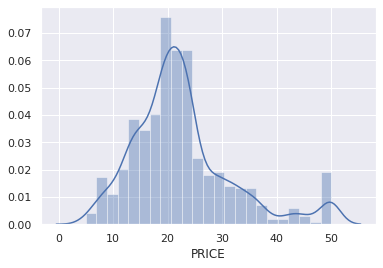

In [5]:
print(f'Max house price is exactly: ${boston_df["PRICE"].max()*1000}')
sns.distplot(boston_df['PRICE'])

Price data is skewed by some prices being censored at 50.

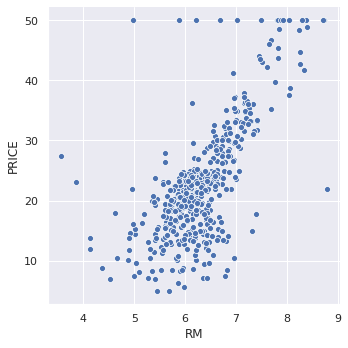

In [6]:
sns.relplot(x="RM", y="PRICE", data=boston_df)
plt.show()

Remove rows where price is exactly 50.

In [7]:
boston_df = boston_df[
    ~(boston_df['PRICE'] == 50)]

In [8]:
correlations = boston_df.corr()
THRESHOLD = .68
features = set()
print('The following features are highly correlated:')
## Go through correlations and note ones that are significant (ignoring half the matrix along diagonal)
for i, (columnName, columnData) in enumerate(correlations.iteritems()):
    for j,row in enumerate(columnData):
        if j >= i:
            # Exit, we've hit the diagonal after which consists of duplicates
            break
        if abs(row) >= THRESHOLD:
            print(f'    {columnName} and {correlations.index[j]} with {row}')
            features.add(columnName)
            features.add(correlations.index[j])

The following features are highly correlated:
    NOX and INDUS with 0.7651551391191302
    AGE and NOX with 0.727671384035908
    DIS and INDUS with -0.710284380771605
    DIS and NOX with -0.7681220040126878
    DIS and AGE with -0.7430434328255687
    TAX and INDUS with 0.7176777396328365
    TAX and RAD with 0.9089997972869206
    PRICE and RM with 0.6866343142060235
    PRICE and LSTAT with -0.7598374909032524


### A heatmap of features with strong relationships

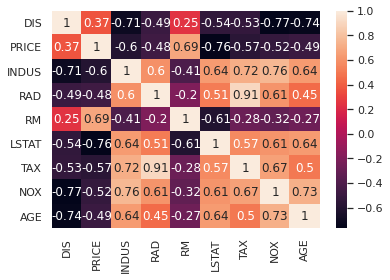

In [9]:
corr_df = boston_df[list(features)].round(2)
sns.heatmap(corr_df.corr(), annot=True)

### Relationship between economic status and price

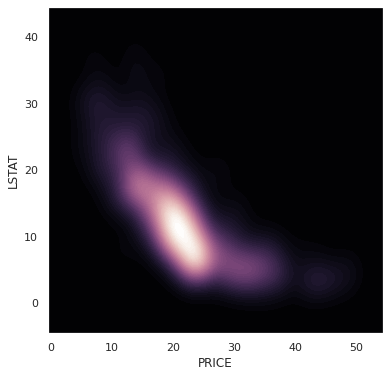

In [10]:
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(boston_df.PRICE, boston_df.LSTAT, cmap=cmap, n_levels=60, shade=True);

### Relationship between Price, # Rooms, Crime, and Pupil-Teacher Ratio
There appears to be a relationship between number of rooms and price. It seems that expensive houses with a high number of rooms have a lower pupil-teacher ratio (lighter color). We also notice that cheaper houses are generally in neighborhoods with a higher crime rate (larger circle).

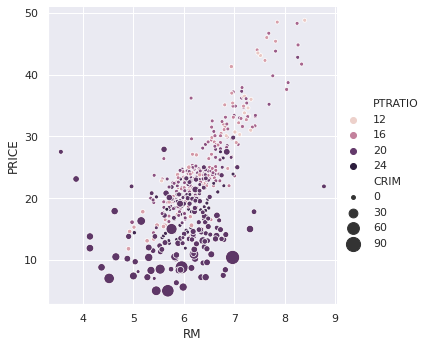

In [11]:
sns.relplot(x='RM', y='PRICE', hue='PTRATIO', size='CRIM', sizes=(15, 200), data=boston_df);

Homes farther away from employment centers have lower nitric oxide concentrations but also have less access to radial highways (and therefore urban centers). Conversely, homes with low nitric oxide levels have more residential land zoned for development.

### Relationship between distance from urban centers and property tax

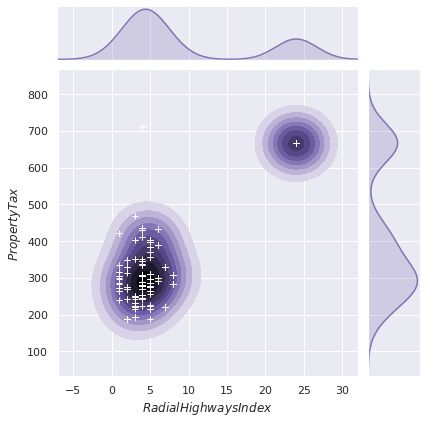

In [12]:
g = sns.jointplot(x="RAD", y="TAX", data=boston_df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Radial Highways Index$", "$Property Tax$");

# Predicting housing prices in Boston

In [13]:
def make_model_from_data(data, target, scaler=None, model=LinearRegression):
    if scaler is not None:
        data = scaler().fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=5)
    assert X_train.shape[0] == y_train.shape[0]
    assert X_test.shape[0] == y_test.shape[0]
    assert X_train.shape[0] != y_test.shape[0]
    assert X_test.shape[0] != y_train.shape[0]
    model = model().fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)
    return model, rmse, r2

Reduce data to the features most correlated with price. That is, # rooms and economic status.

In [14]:
data = boston_df[['RM', 'LSTAT']]
target = boston_df['PRICE']

### Comparison of linear regression performance for different methods of normalization

In [15]:
for scaler in (None, StandardScaler, MinMaxScaler):
    _, rmse, r2 = make_model_from_data(data, target, scaler=scaler)
    print(f'Normalization method: {scaler.__name__ if scaler else "None"}\n'
          f'RMSE: {rmse} R2: {r2}\n{"-"*7}')

Normalization method: None
RMSE: 4.434078945115151 R2: 0.7113753157386551
-------
Normalization method: StandardScaler
RMSE: 4.434078945115151 R2: 0.7113753157386552
-------
Normalization method: MinMaxScaler
RMSE: 4.434078945115151 R2: 0.7113753157386551
-------
